#Hybrid-Movie-Recommender system

Most movie recommender system mostly rely on user rating data to predict user ratings and give recommendations. However, the problem is that most movie recommender systems only leverage user data and item data for collaborative filtering. In this following notebook, we will try to implement a neural network that predicts user rating based on
1. User metadata
2. Item metadata
3. Rating matrix

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install pandas==0.23.4

In [3]:
movies = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/movieRec/data/movies.dat",sep="::",header=None,names=['title','genre'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [4]:
movies

,title,genre
1,Toy Story (1995),Animation|Children's|Comedy
2,Jumanji (1995),Adventure|Children's|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama
5,Father of the Bride Part II (1995),Comedy
6,Heat (1995),Action|Crime|Thriller
7,Sabrina (1995),Comedy|Romance
8,Tom and Huck (1995),Adventure|Children's
9,Sudden Death (1995),Action
10,GoldenEye (1995),Action|Adventure|Thriller


## Feature engineering for movies

It seems that the only data we are given are genres and years embedded in the title of the movies, firstly, let's change genres to one-hot encoded vectors and extract years from movie titles

In [5]:
#create one-hot genre vectors
movies = pd.concat((movies,movies['genre'].str.get_dummies()),axis=1)
movies = movies.drop(columns=['genre'])
print(movies)

                                                  title   ...     Western
1                                      Toy Story (1995)   ...           0
2                                        Jumanji (1995)   ...           0
3                               Grumpier Old Men (1995)   ...           0
4                              Waiting to Exhale (1995)   ...           0
5                    Father of the Bride Part II (1995)   ...           0
6                                           Heat (1995)   ...           0
7                                        Sabrina (1995)   ...           0
8                                   Tom and Huck (1995)   ...           0
9                                   Sudden Death (1995)   ...           0
10                                     GoldenEye (1995)   ...           0
11                       American President, The (1995)   ...           0
12                   Dracula: Dead and Loving It (1995)   ...           0
13                                    

In [0]:
movies['time'] = movies['title'].apply(lambda x: int(x[-6:][1:5]))

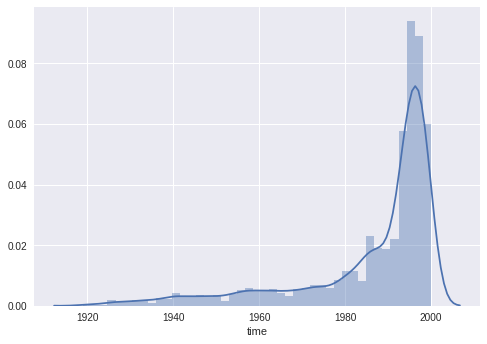

In [7]:
import seaborn as sns

sns.distplot(movies['time'])

Naturally, it seems that most of movies came out from 1990~2000. It seems that the movie industry has been experiencing exponential growth after the mid-80s

In [8]:
movies.loc[:,'Action':'Western'].sum()

Action          503
Adventure       283
Animation       105
Children's      251
Comedy         1200
Crime           211
Documentary     127
Drama          1603
Fantasy          68
Film-Noir        44
Horror          343
Musical         114
Mystery         106
Romance         471
Sci-Fi          276
Thriller        492
War             143
Western          68
dtype: int64

The most popular genres are comedy and Drama followed by action and thriller genres. It will be no surprise if these genres show up a lot in future data analysis. Surprisingly, considering that movielens is mostly an American population, Sci-Fi seems to be pretty low on the list

##User data analysis

Now that we have data analysis for items complete, let's take a look at user data as well.

In [9]:
users = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/movieRec/data/users.dat",sep="::",header=None,names=['gender','age','occupation','zip-code'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [10]:
users

,gender,age,occupation,zip-code
1,F,1,10,48067
2,M,56,16,70072
3,M,25,15,55117
4,M,45,7,02460
5,M,25,20,55455
6,F,50,9,55117
7,M,35,1,06810
8,M,25,12,11413
9,M,25,17,61614
10,F,35,1,95370


According to the README doc of Movielens dataset, age is practically a categorical data since it marks the range of their age. Also, occupation is a label-encoded value for their occupation. Let's change these to more meaningful categories instead of numbers

In [0]:
age_map = {
  1:  "Under 18",
	18:  "18-24",
	25:  "25-34",
	35:  "35-44",
	45:  "45-49",
	50:  "50-55",
	56:  "56+"
}
users['age']=users['age'].replace(age_map)

In [12]:
users['age']

1       Under 18
2            56+
3          25-34
4          45-49
5          25-34
6          50-55
7          35-44
8          25-34
9          25-34
10         35-44
11         25-34
12         25-34
13         45-49
14         35-44
15         25-34
16         35-44
17         50-55
18         18-24
19      Under 18
20         25-34
21         18-24
22         18-24
23         35-44
24         25-34
25         18-24
26         25-34
27         25-34
28         25-34
29         35-44
30         35-44
          ...   
6011       35-44
6012       35-44
6013       25-34
6014       45-49
6015       25-34
6016       45-49
6017       35-44
6018       35-44
6019       25-34
6020       50-55
6021       25-34
6022       25-34
6023       25-34
6024       25-34
6025       25-34
6026       35-44
6027       18-24
6028       18-24
6029       25-34
6030       25-34
6031       18-24
6032       45-49
6033       50-55
6034       25-34
6035       25-34
6036       25-34
6037       45-49
6038         5

In [0]:
occupation_map = {
     0:  "other",
	   1:  "academic/educator",
	   2:  "artist",
	   3:  "clerical/admin",
	   4:  "college/grad student",
	   5:  "customer service",
	   6:  "doctor/health care",
	   7:  "executive/managerial",
	   8:  "farmer",
	   9:  "homemaker",
	  10:  "K-12 student",
	  11:  "lawyer",
	  12:  "programmer",
	  13:  "retired",
	  14:  "sales/marketing",
	  15:  "scientist",
	  16:  "self-employed",
	  17:  "technician/engineer",
	  18:  "tradesman/craftsman",
	  19:  "unemployed",
	  20:  "writer"
}
users['occupation'] = users['occupation'].replace(occupation_map)

In [14]:
users['occupation']

1               K-12 student
2              self-employed
3                  scientist
4       executive/managerial
5                     writer
6                  homemaker
7          academic/educator
8                 programmer
9        technician/engineer
10         academic/educator
11         academic/educator
12                programmer
13         academic/educator
14                     other
15      executive/managerial
16                     other
17         academic/educator
18            clerical/admin
19              K-12 student
20           sales/marketing
21             self-employed
22                 scientist
23                     other
24      executive/managerial
25      college/grad student
26      executive/managerial
27                    lawyer
28         academic/educator
29      executive/managerial
30      executive/managerial
                ...         
6011               scientist
6012               scientist
6013                  writer
6014       aca

## Getting locational data
Conviniently enough there is a python package called "pyzipcode" which allows you to check people's location based on their zipcode. Let's use this package to our advantage


In [15]:
!pip install pyzipcode3 

    100% |████████████████████████████████| 5.6MB 1.1MB/s 


In [0]:
from pyzipcode import ZipCodeDatabase
zipDB = ZipCodeDatabase()

def findState(x):
  try:
    return zipDB[x].state
  except:
    #return Unknown if we cannot find state and error occurs
    return 'Unknown'
users['location'] = users['zip-code'].apply(findState)

In [17]:
#replace zipcode feature with location.
users = users.drop(columns=['zip-code'])
users['location']

1       MI
2       LA
3       MN
4       MA
5       MN
6       MN
7       CT
8       NY
9       IL
10      CA
11      ME
12      FL
13      CA
14      IL
15      VA
16      MD
17      CA
18      CA
19      MI
20      MN
21      WA
22      WI
23      CA
24      NY
25      MA
26      VA
27      PA
28      NY
29      FL
30      PA
        ..
6011    CO
6012    RI
6013    FL
6014    CO
6015    CO
6016    TN
6017    MD
6018    MI
6019    NY
6020    NY
6021    NJ
6022    SD
6023    OH
6024    WI
6025    FL
6026    NY
6027    MD
6028    CA
6029    VA
6030    FL
6031    OH
6032    MN
6033    TX
6034    CA
6035    TX
6036    FL
6037    TX
6038    NY
6039    MA
6040    NY
Name: location, Length: 6040, dtype: object

##Data visualization

Let's see if these categorical data bring any insights that we might use for feature engineering and model building.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


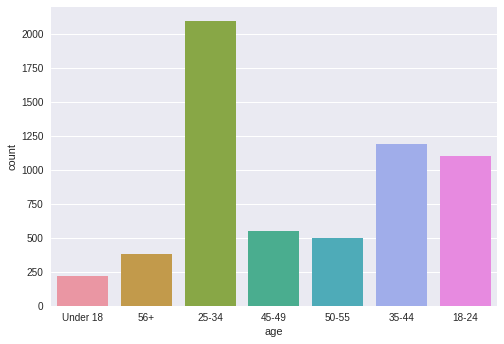

In [18]:
import seaborn as sns

sns.countplot(users['age'])

Seems like that mostly people though 20~40s watch more movies.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


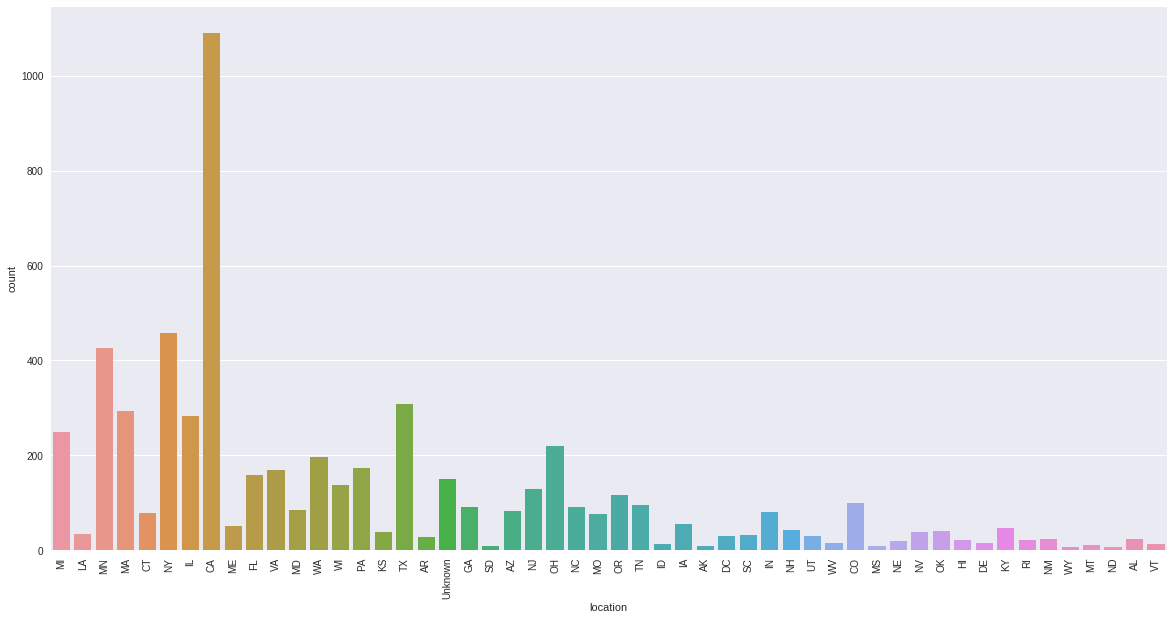

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
sns.countplot(users['location'])

We see that larger states like NY and CA have a lot of movie population. A blunt guess, but it may be because California also happens to have Hollywood.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


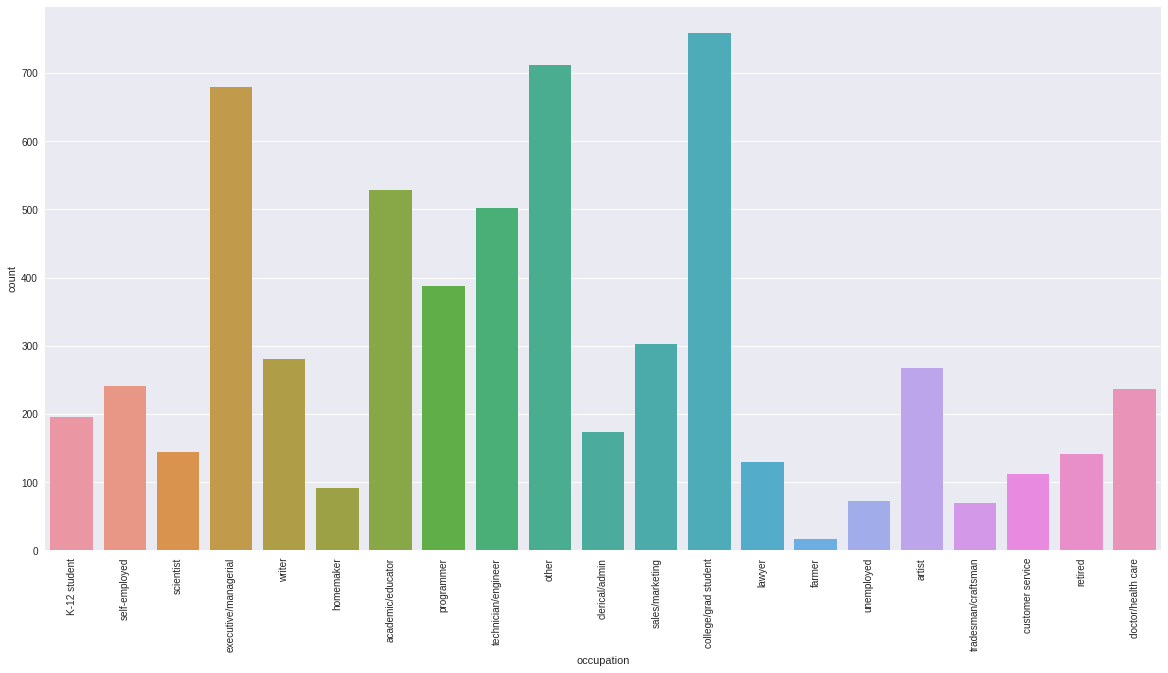

In [20]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
sns.countplot(users['occupation'])

Again since the age data showed that people in their 20s~40s watch most movies, it's not suprising the college students watch a lot of movies. Also, people who mostly work indoor or have engineering-related occupation seems to watch more movies then others. Interestingly enough creactive occupations like artists and writers do not watch a lot of movies.

In [21]:
users = pd.get_dummies(users)
users

,gender_F,gender_M,age_18-24,age_25-34,age_35-44,age_45-49,age_50-55,age_56+,age_Under 18,occupation_K-12 student,occupation_academic/educator,occupation_artist,occupation_clerical/admin,occupation_college/grad student,occupation_customer service,occupation_doctor/health care,occupation_executive/managerial,occupation_farmer,occupation_homemaker,occupation_lawyer,occupation_other,occupation_programmer,occupation_retired,occupation_sales/marketing,occupation_scientist,occupation_self-employed,occupation_technician/engineer,occupation_tradesman/craftsman,occupation_unemployed,occupation_writer,location_AK,location_AL,location_AR,location_AZ,location_CA,location_CO,location_CT,location_DC,location_DE,location_FL,...,location_IA,location_ID,location_IL,location_IN,location_KS,location_KY,location_LA,location_MA,location_MD,location_ME,location_MI,location_MN,location_MO,location_MS,location_MT,location_NC,location_ND,location_NE,location_NH,location_NJ,location_NM,location_NV,location_NY,location_OH,location_OK,location_OR,location_PA,location_RI,location_SC,location_SD,location_TN,location_TX,location_UT,location_Unknown,location_VA,location_VT,location_WA,location_WI,location_WV,location_WY
1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##Rating matrix

Now let's move on to our final data. Ratings matrix. We may think that we don't have much things to do with this data but, we can extract some additional data from the ratings matrix as well. We can generate synthetic data such as percentage of watched movies per genre. Additionally, for each movie, we may also add its fan base in terms of gender, occupation, and age. Most importantly, its average rating as well.

In [22]:
ratings = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/movieRec/data/ratings.dat",sep="::",header=None,names=['userID','movieID','rating','timestamp'])
ratings

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,userID,movieID,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
5,1,1197,3,978302268
6,1,1287,5,978302039
7,1,2804,5,978300719
8,1,594,4,978302268
9,1,919,4,978301368


Let us first obtain the ratings matrix before we extract synthetic features

In [0]:
ratings = ratings.pivot_table(index=['userID'],columns=['movieID'],values='rating')

In [24]:
ratings

movieID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
userID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4.0,NaN,4.0,NaN,3.0,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,4.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN


We notice that the dataframe has only 3706 columns and some 100 movies were never even rated. Let's remove these movies from movies dataframe for consistancy

In [0]:
#get missing movies
missing_movies = set(movies.index) - set(ratings.columns)

In [0]:
#remove imissing movies
missing_movies = list(missing_movies)
movies = movies[~movies.index.isin(missing_movies)]

In [27]:
movies.shape

(3706, 20)

Since we finished processing the ratings matrix we can finally dive into making synthetic features. Let's first get the average rating for both movie and user

In [0]:
n_movies = 3706
n_users = 6040

#obtain averages from ratings matrix
users_watched = n_movies-ratings.isna().sum(axis=1)
users_average_rating = ratings.sum(axis=1)/users_watched
movies_watched = n_users-ratings.isna().sum(axis=0)
movies_average_rating = ratings.sum(axis=0)/movies_watched

Now, let's get to the serious part. For the users, let's take all the movies they watched and calculate the percentage of each genre as well as the mean year for the user's movies. Same goes for the movies. We can calculate gender and occupation distribution in percentages using the same method.

In [29]:
user_add_on = pd.DataFrame()
movie_add_on = pd.DataFrame()

for userID in ratings.index:
  non_zero = movies.loc[~ratings.loc[userID].isna()].index.tolist()
  watched_movies = movies.loc[non_zero].loc[:,'Action':'time']
  user_add_on = pd.concat((user_add_on,watched_movies.sum()/len(watched_movies)),axis=1)
for movieID in ratings.columns:
  non_zero = users.loc[~ratings.loc[:,movieID].isna()].index.tolist()
  watched_users = users.loc[non_zero].loc[:,'gender_F':'occupation_writer']
  movie_add_on = pd.concat((movie_add_on,watched_users.sum()/len(watched_users)),axis=1)
print(user_add_on)
print(movie_add_on)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


                       0            0     ...                 0            0
Action          0.094340     0.434109     ...          0.065041     0.123167
Adventure       0.094340     0.147287     ...          0.081301     0.064516
Animation       0.339623     0.000000     ...          0.105691     0.011730
Children's      0.377358     0.000000     ...          0.138211     0.017595
Comedy          0.264151     0.193798     ...          0.528455     0.299120
Crime           0.037736     0.093023     ...          0.016260     0.073314
Documentary     0.000000     0.000000     ...          0.000000     0.029326
Drama           0.396226     0.612403     ...          0.227642     0.542522
Fantasy         0.056604     0.007752     ...          0.040650     0.017595
Film-Noir       0.000000     0.007752     ...          0.048780     0.029326
Horror          0.000000     0.015504     ...          0.008130     0.064516
Musical         0.264151     0.000000     ...          0.341463     0.026393

In [0]:
#make sure these user/movie data have the right columns
user_add_on.columns = ratings.index
movie_add_on.columns = ratings.columns

In [0]:
#transpose user_add_on
user_add_on = user_add_on.T

In [0]:
#transpose movie_add_on
movie_add_on = movie_add_on.T

In [0]:
#merge the add_on synthetic features to original dataframes
users = users.join(user_add_on)
movies = movies.join(movie_add_on)

## Representation of rating's matrix
Although we have a complete feature for both users and contents, we still want to represent ratings information somehow. However, the problem is that the data is way too sparse and if we will end up having adding thousands of more features. Not only that this is inefficient, but also computationally hard even on GPU with thousands of features. To overcome this problem, let's use PCA to reduce the dimension and treat each row as an embedding to resolve the sparcity issue.

In [0]:
#fill NaN values with 0 for PCA
ratings = ratings.fillna(0)

In [0]:
from sklearn.decomposition import PCA

#reduce dimensions to 5 principle components using PCA
pca = PCA(n_components=5)
vectorized_user = pca.fit_transform(ratings.values)
vectorized_movie = pca.fit_transform(np.transpose(ratings.values))

In [0]:
#convert to DataFrame
vectorized_user = pd.DataFrame(data=vectorized_user,index=ratings.index,columns=['u1','u2','u3','u4','u5'])
vectorized_movie = pd.DataFrame(data=vectorized_movie,index=ratings.columns,columns=['m1','m2','m3','m4','m5'])

In [0]:
#join ratings embeddings to original
users = users.join(vectorized_user)
movies = movies.join(vectorized_movie)

In [38]:
print(users.shape)
print(movies.shape)

(6040, 106)
(3706, 55)


##Preparing data for hybrid model

Lastly, we will use the complete dataset of both movies and users to generate our training set

In [0]:
from sklearn.preprocessing import RobustScaler

#normalization and feature scaling with RobustScaler
scaler = RobustScaler()
#don't include title
movies_values=scaler.fit_transform(movies.loc[:,'Action':'m5'])
users_values=scaler.fit_transform(users)
movies.loc[:,'Action':'m5'] = movies_values
users.loc[:,'gender_F':'u5'] = users_values

In [40]:
#reimport ratings matrix
ratings = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/movieRec/data/ratings.dat",sep="::",header=None,names=['userID','movieID','rating','timestamp'])
ratings = ratings.drop(columns=['timestamp'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [0]:
#drop irrelevant/non_numeric-feature
movies = movies.drop(columns=['title'])

In [0]:
#create matrix and populating it is much faster than appending rows to empty dataframe
final_user_features = np.zeros((ratings.shape[0],106))
final_movie_features = np.zeros((ratings.shape[0],54))
i=0
#obtain user/movie data per rating
for row in ratings.iterrows():
  user_feature,movie_feature = users.loc[row[1]['userID']].values,movies.loc[row[1]['movieID']].values
  final_user_features[i] = user_feature
  final_movie_features[i] = movie_feature
  i+=1

In [0]:
#get lables
labels = ratings.pop('rating')

In [0]:
#save and export for training model
np.save("/content/gdrive/My Drive/Colab Notebooks/movieRec/data/user_features.npy",final_user_features)
np.save("/content/gdrive/My Drive/Colab Notebooks/movieRec/data/movie_features.npy",final_movie_features)
np.save("/content/gdrive/My Drive/Colab Notebooks/movieRec/data/labels.npy",labels.values)